## ***构建报价选择算法并设置通用参数***



#### 1 按省份选择供应商
##### 1.1 限制供应商数量输出结果
           按照当前报价的结果
           如何修改报价以及阶梯优惠获得更大收益

In [1]:
## 优化函数
def select_sorted_population(fitness, population, length):
    global population_size
    sort_dict = {}
    for i in range(len(population)):
        sort_dict[(fitness[i], 1 / fitness[i])] = i

    sorted_key = sorted(sort_dict.keys(), key=operator.itemgetter(0), reverse=True)

    sorted_index = [sort_dict[i] for i in sorted_key]
    sorted_population = [population[i] for i in sorted_index]

    return sorted_population[:length]

# 轮赌盘选择算子
def selection(fitness, num):
    def select_one(fitness, fitness_sum):
        size = len(fitness)
        i = random.randint(0, size - 1)
        while True:
            if random.random() < fitness[i] / fitness_sum:
                return i
            else:
                i = (i + 1) % size

    res = set()
    fitness_sum = sum(fitness)
    while len(res) < num:
        t = select_one(fitness, fitness_sum)
        res.add(t)
    return res

# 杂交算子
def crossover(parent1, parent2):

    a = random.randint(1, len(parent1) - 1)
    parent2[:a], parent1[:a] = parent1[:a], parent2[:a]

    return parent1, parent2


def get_two(length):
    b=a = random.randint(0,length-1)
    while a==b:
        b = random.randint(0,length-1)
    if a>b:
        return b,a
    else: return a,b

def mutaion_exchange(s):
    # 自己手写的2变换
    a, b = get_two(len(s))
    for i in range(a, (a + b) // 2 + 1):
        s[i], s[b + a - i] = s[b + a - i], s[i]

    return s

# 滑动变异
def slide_mutation(s):
    a, b = get_two(len(s))
    t = s[a]
    for i in range(a + 1, b + 1):
        s[i - 1] = s[i]
    s[b] = t
    return s

def get_fitness_one(p1,province_list):
    chorme = dict(zip(province_list,p1))
    fitness = 0
    for i in top_express:
         fitness+=  before_discount.filter((pl.col("express_code")==i)&(pl.col("province").is_in([k for k,v in chorme.items() if v == i]))).select(pl.col('cost').sum())[0,0]
    return 1/fitness

# SMB
def select_best_mutaion(s, province_list):
    s_res = [mutaion_exchange(s[:]), slide_mutation(s[:])]
    res = [get_fitness_one(s_res[0], province_list), get_fitness_one(s_res[1], province_list)]

    min_index = res.index(max(res))

    return s_res[min_index]  

In [2]:
## 适应度计算函数
def get_fitness(chromosome_list,province_list):
        fitness_ratio_list = []
        for chorme in chromosome_list:
            chorme_1 = dict(zip(province_list,chorme))
            fitness = 0
            for i in top_express:
                     fitness+=  before_discount.filter((pl.col("express_code")==i)&(pl.col("province").is_in([k for k,v in chorme_1.items() if v == i]))).select(pl.col('cost').sum())[0,0]
            fitness_ratio_list.append(1/fitness)        
        return fitness_ratio_list

In [3]:
## 各供应商若承接各省份对应的折扣前cost
import polars as pl
import pandas as pd
import random
import itertools
import operator
df = pd.read_excel('quotation data/quotation simulation_v2.xlsx',sheet_name=None);
sheet_name_list = list(df.keys())
                       
before_discount =  pl.read_excel('quotation data/quotation simulation_v2.xlsx',sheet_name="2022 zto_v2")
before_discount = before_discount[0:124,0:6].with_columns(pl.lit("2022 zto_v2").alias('express'))

for i in  range(1,len(sheet_name_list)):
    before_discount_1 =  pl.read_excel('quotation data/quotation simulation_v2.xlsx',sheet_name=sheet_name_list[i])
    before_discount_1 = before_discount_1[0:124,0:6].with_columns(pl.lit(sheet_name_list[i]).alias('express'))
    before_discount = pl.concat([before_discount,before_discount_1],how = 'vertical')

## 将对应供应商名称编码话
dict_express =dict(zip(list(before_discount.select(pl.col("express").unique().list())[0,0]),[chr(i) for i in range(ord('a'),ord('h')+1)]))
dict_express
before_discount = before_discount.with_column(pl.col("express").apply(lambda x:dict_express.get(x)).alias("express_code"))

In [4]:
## 限制供应商的选择数量生产组合
 ##以限制三家供应商的情况
## 首先选择三家总价模拟最低的供应商，贪心优化
import random
top_express = before_discount.groupby("express_code").agg(pl.col("cost").sum()).sort("cost").head(3).select(pl.col("express_code")).to_numpy().tolist()
from itertools import chain
top_express = list(chain.from_iterable(top_express))
province_list = list(chain.from_iterable(before_discount.select(pl.col("province").unique()).to_numpy().tolist()))
chromosome_list = []
population_size = 50
for i in range(population_size):
    chromosome_list.append([random.sample(top_express,1)[0] for _ in range(0,int((before_discount.select(pl.col("province").unique().count()).to_numpy()+1)[0]))])


In [5]:
import numpy as np
import operator
from matplotlib import pyplot as plt
import seaborn as sns
## 循环优化
fitness_ratio_list = get_fitness(chromosome_list,province_list)
fitness_ratio_add = list(itertools.accumulate(fitness_ratio_list))
fitness_ratio_add = [x/sum(fitness_ratio_list) for x in fitness_ratio_add ]
import itertools
best_result = []
best_fitness = []
generation = 500
picture = [0.001,0.005,0.01,0.02,0.05,0.08,0.1,0.2,0.3,0.5,0.8,1]
picture_new = [i * generation for i in picture]
population_cur = chromosome_list
p_mutation = 0.02
d = 0

for t in range(0,generation,1):
    if t and t % 100 == 0:
        print(t)
    ## 选出比较好的前1/4样本
    population_next = select_sorted_population(fitness_ratio_list,population_cur,len(chromosome_list)//4)
    for i in range(population_size):
        a,b = selection(fitness_ratio_list,2)
        child1,child2 = crossover(population_cur[a],population_cur[b])
            # 变异
        if random.random() < p_mutation:
                child1 = select_best_mutaion(child1,province_list)
        if random.random() < p_mutation:
                child2 = select_best_mutaion(child2,province_list)      
        population_next.append(child1)
        population_next.append(child2)

        # 选出下一代的种群
    fitness_ratio_list = get_fitness(population_next,province_list)
    population_next = select_sorted_population(fitness_ratio_list, population_next, population_size)
    population_cur = population_next
    fitness_ratio_list = get_fitness(population_cur,province_list)
    fitness_ratio_add = list(itertools.accumulate(fitness_ratio_list))
    fitness_ratio_add = [x/sum(fitness_ratio_list) for x in fitness_ratio_add ]
    best_result.append(population_cur[int(fitness_ratio_list.index(max(fitness_ratio_list)))])
    best_fitness.append(max(fitness_ratio_list))


100
200
300
400


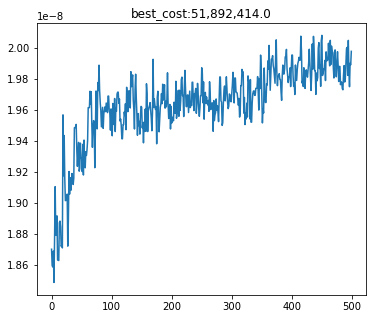

In [6]:

best_cost = round(1/get_fitness_one(best_result[best_fitness.index(max(best_fitness))],province_list),0)
x = [i for i in range(generation)]
fig1 = plt.figure('figure', figsize=(13, 5)).add_subplot(121)
fig1.plot(x, best_fitness)
fig1.set_title("best_cost:"+ str(format(best_cost,',')))
plt.show()

In [9]:
best_result[best_fitness.index(max(best_fitness))]

['d',
 'g',
 'g',
 'd',
 'd',
 'd',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'g',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'g',
 'd',
 'g',
 'f',
 'f',
 'g',
 'f',
 'g']

In [14]:
dict(zip(province_list,best_result[best_fitness.index(max(best_fitness))]))

{'河北': 'd',
 '天津': 'g',
 '湖北': 'g',
 '贵州': 'd',
 '西藏': 'd',
 '内蒙古': 'd',
 '吉林': 'f',
 '新疆': 'f',
 '海南': 'f',
 '江西': 'f',
 '浙江': 'f',
 '江苏': 'f',
 '四川': 'g',
 '辽宁': 'f',
 '广西': 'f',
 '山东': 'f',
 '湖南': 'f',
 '甘肃': 'f',
 '陕西': 'f',
 '广东': 'f',
 '云南': 'f',
 '重庆': 'f',
 '上海': 'f',
 '安徽': 'f',
 '河南': 'g',
 '福建': 'd',
 '山西': 'g',
 '北京': 'f',
 '黑龙江': 'f',
 '青海': 'g',
 '宁夏': 'f'}

In [29]:
before_discount.groupby("express_code").agg(pl.col("cost").sum()).sort("cost").head(3)

express_code,cost
str,f64
"""h""",5.2928e7
"""c""",5.5898e7
"""a""",6.0030e7


#### 2 按平台选择供应商